In [88]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from statistics import mean

In [89]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(dev)

cuda:0


In [90]:
t = transforms.Compose([
                        transforms.Resize(32),
                        transforms.CenterCrop(32),
                        transforms.ToTensor()
])
train_data = datasets.CIFAR10(root = './data', train = True, transform=t, download = True)
temp = train_data.class_to_idx
labelmap = {y:x for x,y in temp.items()}
print(labelmap)

Files already downloaded and verified
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [91]:
class NET(nn.Module):

  def __init__(self, out1, out2, n1, n2):
    super(NET,self).__init__()

    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=out1, kernel_size=(4,4), stride=(1,1), padding=2),
        nn.BatchNorm2d(out1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )

    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=(3,3), stride=(1,1), padding=1),
        nn.BatchNorm2d(out2),
        nn.ReLU(),
    )

    self.inshape = out2 * 16 * 16 

    self.fc1 = nn.Sequential(
        nn.Linear(in_features=self.inshape, out_features=n1),
        nn.BatchNorm1d(n1),
        nn.ReLU()
    )

    self.fc2 = nn.Sequential(
        nn.Linear(in_features=n1, out_features=n2),
        nn.BatchNorm1d(n2),
        nn.ReLU()
    )

    self.out = nn.Linear(in_features=n2, out_features=10)

  def forward(self,x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    #print(x.shape)
    x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))

    x = self.fc1(x)
    x = self.fc2(x)
    return self.out(x)

In [92]:
model = NET(32,64,512,256)
model.to(dev)

NET(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [93]:
batch_size = 100
epochs = 20
lr = 0.001
momentum = 0.8
dataset_size = len(train_data)
show_every = 50

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

stats_dict = {'all_loss':[], 'mean_loss':[], 'acc':[]}

print(f'{int(dataset_size/batch_size)} batches per epoch.')
for epoch in range(epochs):

  correct, incorrect, batch_counter = 0,0,0
  temp_loss_list = []

  for x,y in loader :

    opt.zero_grad()
    x,y = x.to(dev), y.to(dev)
    yhat = model.forward(x)

    for i in range(len(yhat)):
      if torch.argmax(yhat[i]) == y[i]:
        correct += 1
      else :
        incorrect += 1

    loss = loss_fn(yhat,y)
    temp_loss_list.append(loss.item())
    stats_dict['all_loss'].append(loss.item())

    loss.backward()
    opt.step()

    if batch_counter % show_every == 0 :
      print(f'{batch_counter} --> ', end='', flush=True)

    batch_counter += 1

  meanloss = mean(temp_loss_list)
  accuracy = (correct / (incorrect + correct)) * 100

  stats_dict['mean_loss'].append(meanloss)
  stats_dict['acc'].append(accuracy)

  print()
  print(f'Epoch : {epoch} | Loss : {meanloss} | Accuracy : {round(accuracy,3)}')
  print('-' * 50)

500 batches per epoch.
0 --> 50 --> 100 --> 150 --> 200 --> 250 --> 300 --> 350 --> 400 --> 450 --> 
Epoch : 0 | Loss : 1.4574523661136627 | Accuracy : 49.724
--------------------------------------------------
0 --> 50 --> 100 --> 150 --> 200 --> 250 --> 300 --> 350 --> 400 --> 450 --> 
Epoch : 1 | Loss : 1.052418722987175 | Accuracy : 64.342
--------------------------------------------------
0 --> 50 --> 100 --> 150 --> 200 --> 250 --> 300 --> 350 --> 400 --> 450 --> 
Epoch : 2 | Loss : 0.8358187985420227 | Accuracy : 72.342
--------------------------------------------------
0 --> 50 --> 100 --> 150 --> 200 --> 250 --> 300 --> 350 --> 400 --> 450 --> 
Epoch : 3 | Loss : 0.6638343816995621 | Accuracy : 79.176
--------------------------------------------------
0 --> 50 --> 100 --> 150 --> 200 --> 250 --> 300 --> 350 --> 400 --> 450 --> 
Epoch : 4 | Loss : 0.5117732190489769 | Accuracy : 85.136
--------------------------------------------------
0 --> 50 --> 100 --> 150 --> 200 --> 250 --

In [94]:
def plot_stats(stat_dict, msges, ax):
  for i in zip(stat_dict,msges,ax):
    i[2].plot(stat_dict[i[0]], linewidth = 3)
    i[2].set_title(i[1])
    i[2].grid(True)

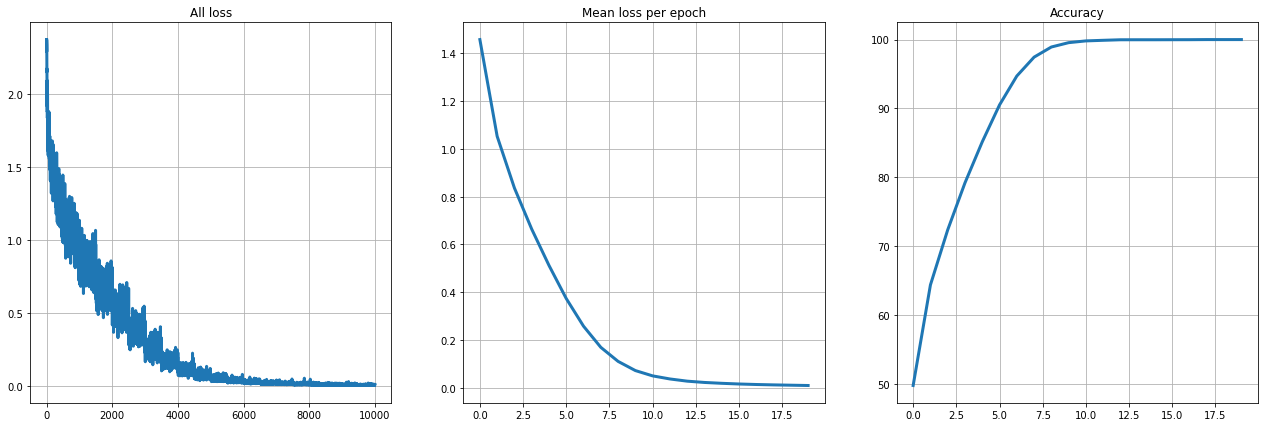

In [95]:
fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (22,7))
ax = ax.flatten()
plot_stats(stats_dict, ['All loss','Mean loss per epoch','Accuracy'],ax)